In [83]:
from fastai2.tabular.all import *

In [61]:
from fastai2.metrics import *

In [84]:
from sklearn.model_selection import train_test_split

In [85]:
SEED = 42

# Read Data

In [86]:
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()

(#3) [Path('C:/Users/user/.fastai/data/adult_sample/adult.csv'),Path('C:/Users/user/.fastai/data/adult_sample/export.pkl'),Path('C:/Users/user/.fastai/data/adult_sample/models')]

In [87]:
df = pd.read_csv(path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [88]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']

In [89]:
cont_names = ['age', 'fnlwgt', 'education-num']

In [90]:
dep_var = "salary"

In [91]:
train_df, test_df = train_test_split(df, test_size=0.3, 
                                     random_state=SEED, 
                                     stratify=df[dep_var])

# Preprocessing

In [92]:
cat = Categorify()

In [93]:
imp = FillMissing(fill_strategy=FillStrategy.mode, 
                  add_col=True)

In [94]:
norm = Normalize()

In [95]:
procs = [cat, imp, norm]

# DataBunch

In [ ]:
TabularPandas

In [96]:
to = TabularPandas(train_df, 
                   y_block = CategoryBlock(), 
                   y_names = dep_var,
                   splits = RandomSplitter()(range_of(train_df)),
                   cat_names = cat_names,
                   cont_names = cont_names,
                   procs = procs)

In [60]:
dls = to.dataloaders(batch_size=32)

# Learner

In [62]:
cbs = [TrackerCallback(monitor="roc_auc_score"), ReduceLROnPlateau("roc_auc_score", patience=3)]

In [73]:
learn = tabular_learner(dls, metrics=RocAuc(),
                        layers=[100, 100], 
                        #emb_szs=[], 
                        #loss_func,
                        #opt_func=Adam,
                        #opt_func, 
                        cbs=cbs,
                        #moms=(0.95, 0.85, 0.95),
                        wd=None, wd_bn_bias=False, train_bn=True
                       )

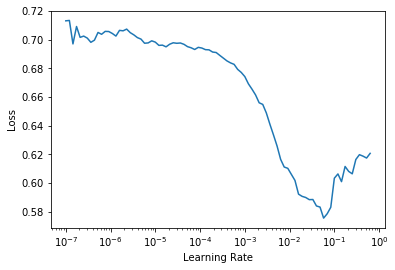

In [74]:
lr_min, lr_steep = learn.lr_find()

In [75]:
learn.fit_one_cycle(2, lr_max=lr_steep)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.376902,0.372615,0.729282,00:06
1,0.371939,0.356536,0.728120,00:06


In [76]:
x = learn.cbs[3]

In [77]:
x.best

0.7292822633278911

# Optuna

In [223]:
import optuna

In [142]:
EPOCHS = 2

In [149]:
def objective(trial):
    #Q: How do I define fill value?
    cat = Categorify()
    fillstraFillStrategy.mode
    imp = FillMissing(fill_strategy=fill_strategy,
                      add_col=True)

    norm = Normalize(mean=5)
    procs = [cat, imp, norm]

    # DataBunch
    to = TabularPandas(train_df, 
                       y_block = CategoryBlock(), 
                       y_names = dep_var,
                       splits = RandomSplitter()(range_of(train_df)),
                       cat_names = cat_names,
                       cont_names = cont_names,
                       procs = procs)

    dls = to.dataloaders(batch_size=512)
    
    n_layers = trial.suggest_int("n_layers", 2, 5)
    layer_sizes = L()
    
    for i in range(n_layers):
        layer_size = trial.suggest_int("layer_size_{}".format(i), 1, 10)
        layer_sizes.append(50 * layer_size)

    learn = tabular_learner(dls, metrics=RocAuc(),
                            layers=layer_sizes, 
                            #emb_szs=[], 
                            #loss_func,
                            #opt_func, 
                            cbs=cbs,
                            #lr=0.001, moms=(0.95, 0.85, 0.95)
                            #wd=None, wd_bn_bias=False, train_bn=True
                           )
    
    learn.fit_flat_cos(EPOCHS)

    return learn.cbs[3].best

In [150]:
optuna.logging.set_verbosity(0)
pruner = optuna.pruners.NopPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=5, timeout=600)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.405053,0.476074,0.500000,00:01
1,0.367246,0.395882,0.622816,00:01


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.380378,0.460215,0.538600,00:02
1,0.356267,0.383154,0.686228,00:02


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.383377,0.471449,0.507842,00:01
1,0.358828,0.389051,0.687395,00:01


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.394768,0.472647,0.671344,00:01
1,0.363715,0.388233,0.732455,00:01


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.383316,0.457935,0.591756,00:01
1,0.359925,0.386684,0.720578,00:01


In [151]:
print("Number of finished trials: {}".format(len(study.trials)))

Number of finished trials: 5


In [152]:
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))

Best trial:
  Value: 0.7324549813617556


In [153]:
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Params: 
    n_layers: 2
    layer_size_0: 7
    layer_size_1: 3


# Test Results

In [154]:
test_dl = learn.dls.test_dl(test_df.drop(['salary'], axis=1))

In [155]:
probs = learn.get_preds(dl=test_dl)

In [156]:
probs = probs[0][:,1]

In [157]:
from sklearn.metrics import roc_auc_score

In [158]:
scorer = RocAuc()

In [159]:
roc_auc_score(test_df[dep_var], probs)

0.8787596624870792

# Desired API

In [160]:
import numpy as np

## Preprocessing

In [ ]:
fill = HpInt(start_range=1, end_range=100)

In [ ]:
fill_strategy = HpOptions("fill_strategy", 
                          [FillStrategy.mode, 
                           FillStrategy.median, 
                           FillStrategy.constant(5, fill)])

In [ ]:
# or less preferred

In [ ]:
fill_dict = {"mode" : FillStrategy.mode, "median" : FillStrategy.median, "constant" : FillStrategy.constant(5, fill)}
fill_strategy = HpOptions("fill_strategy", ["mode", "median", "constant"], fill_dict)

In [ ]:
add_col = HpBool("missing_col_bool")

In [64]:
imp = FillMissing(fill_strategy=fill_strategy, add_col=add_col)

#### Option A

In [65]:
norm = Normalize(mean=HpFloat("norm_mean", start=2, end=10, dist="uniform"))

In [66]:
procs = [Categorify, imp, HpToggle(norm)]

#### Option B

In [ ]:
norm = HpToggle(Normalize(mean=HpFloat(start=2, end=10, dist="uniform")))

In [82]:
procs = [Categorify, imp, norm]

## DataBunch

In [67]:
to = TabularPandas(train_df, 
                   y_block = CategoryBlock(), 
                   y_names = dep_var,
                   splits = RandomSplitter()(range_of(train_df)),
                   cat_names = cat_names,
                   cont_names = cont_names,
                   procs = procs)

#### Option A

In [ ]:
bs_pow = HpInt(0, 8)

In [122]:
dls = to.dataloaders(batch_size=2**bs_pow)
#or
dls = to.dataloaders(batch_size=HpConst(2)**bs_pow)

#### Option B

In [122]:
dls = to.dataloaders(batch_size=HpBatchSizeFinder(...))

## Learner

In [123]:
from fastai2.metrics import *

In [124]:
cbs = [TrackerCallback(monitor="roc_auc_score")]

### #Layers + Layer Sizes

#### Option A

In [ ]:
layer_size_hp = HpFuncInt(func=np.multiply, base_value=50, min_int=1, max_int=7)
layers = HpVarList(min_len=1, max_len=5, layer_size_hp)

#### Option B

In [ ]:
layer_size_hp = HpInt(min=1, max=7)
layers = HpVarList(min_len=1, max_len=5, value=50 * layer_size_hp) 
#TODO: think of how to distinguish between same value for all items in list and different ones?

### Optimizer

In [ ]:
opt_dict = {"SGD" : SGD, "ADAM" : Adam, "LAMB" : fastai2.optimizer.Lamb()}

In [ ]:
optimizer = HpOptions(["SGD", "ADAM", "LAMB"], opt_dict)

In [ ]:
if optimizer == "SGD":
    sqr_mom = Adam()
    Lamb(sqr_mom)

#### Option B

In [ ]:
def opt_name_to_opt(name): if name.containts("SGD") return SGD else Adam

In [ ]:
optimizer = HpOptions(["SGD", "ADAM", "LAMB"], opt_name_to_opt)

#### Option C

In [ ]:
optimizer = HpOptions([SGD, Adam, Lamb])

### Init Learner

In [ ]:
learn = tabular_learner(dls, metrics=RocAuc(),
                        layers=layers
                        
                        #loss_func,
                        opt_func = opt_func
                        cbs=cbs,
                        #moms=(0.95, 0.85, 0.95)
                        #wd=None, wd_bn_bias=False, train_bn=True
                        #emb_szs=[],
                       )

### LR Finder

In [ ]:
lr = HpLrFinder(finder_type="fastai", which="steep", kwargs=...)

In [220]:
learn.fit_flat_cos(3, lr=lr)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.365408,0.357305,0.679694,00:02
1,0.359781,0.342277,0.746188,00:02
2,0.353049,0.334768,0.758574,00:02
